In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
import pathlib
from sklearn.metrics import classification_report

import tensorflow as tf
from keras import layers

# Setup

In [2]:
train_dir = pathlib.Path("./train/")
test_dir = pathlib.Path("./test/")

In [3]:
image_count = len(list(pathlib.Path("").glob('*/*/*.jpg')))
print("All images: ", image_count)

All images:  1658


In [4]:
batch_size = 17
img_height = 180
img_width = 180

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 1156 files belonging to 9 classes.


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 502 files belonging to 9 classes.


In [7]:
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)
for i in class_names:
    print(i)

['Ajwa', 'Galaxy', 'Medjool', 'Meneifi', 'NabtatAli', 'Rutab', 'Shaishe', 'Sokari', 'Sugaey']
Ajwa
Galaxy
Medjool
Meneifi
NabtatAli
Rutab
Shaishe
Sokari
Sugaey


In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1156).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Analysis

Text(0.5, 1.0, 'Number of images per class in training set')

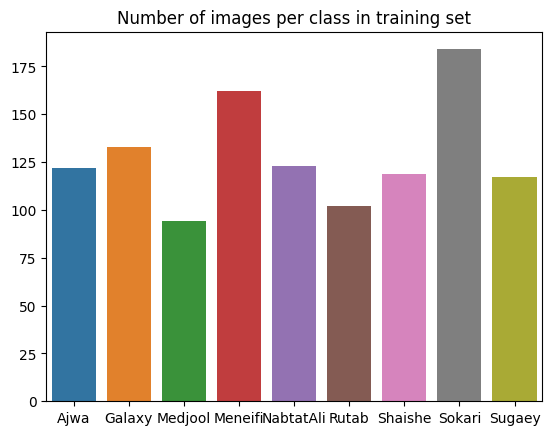

In [9]:
classesNambers = []
ourClasses = []
rootdir = './train/'
for file in os.listdir(rootdir):
    d = os.path.join(rootdir, file)
    if os.path.isdir(d):
        x =d.split('/')
        classesNambers.append(len(os.listdir(d)))
        ourClasses.append(x[-1])

sns.barplot(x=ourClasses, y=classesNambers).set_title('Number of images per class in training set')

Text(0.5, 1.0, 'Number of images per class in test set')

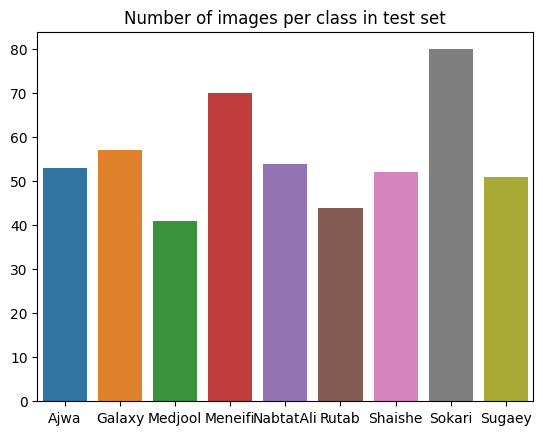

In [10]:
classesNambers = []
ourClasses = []
rootdir = './test/'
for file in os.listdir(rootdir):
    d = os.path.join(rootdir, file)
    if os.path.isdir(d):
        x =d.split('/')
        classesNambers.append(len(os.listdir(d)))
        ourClasses.append(x[-1])

sns.barplot(x=ourClasses, y=classesNambers).set_title('Number of images per class in test set')

# Preprocessing

Normalize the data

In [11]:
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# the pixel values are now in `[0,1]`.

# Architecture

In [12]:
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape = (img_height, img_width, 3), name='inputLayer')
x = base_model(inputs, training = False)
x = layers.GlobalAveragePooling2D(name='poolingLayer')(x)
x = layers.Dense(101, name='outputLayer')(x)
outputs = layers.Activation(activation="softmax", dtype=tf.float32, name='activationLayer')(x)

model = tf.keras.Model(inputs, outputs, name = "FeatureExtractionModel")

# Training

In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
model.summary()

Model: "FeatureExtractionModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 180, 180, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 poolingLayer (GlobalAverage  (None, 1280)             0         
 Pooling2D)                                                      
                                                                 
 outputLayer (Dense)         (None, 101)               129381    
                                                                 
 activationLayer (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 12

In [15]:
epochs = 35
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/35


c:\Program Files\Python310\lib\site-packages\keras\backend.py:5604: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


68/68 [==============================] - 38s 467ms/step - loss: 1.5223 - accuracy: 0.6185 - val_loss: 0.7363 - val_accuracy: 0.8406
Epoch 2/35
68/68 [==============================] - 33s 483ms/step - loss: 0.5553 - accuracy: 0.8979 - val_loss: 0.4711 - val_accuracy: 0.9104
Epoch 3/35
68/68 [==============================] - 33s 490ms/step - loss: 0.3714 - accuracy: 0.9351 - val_loss: 0.3681 - val_accuracy: 0.9104
Epoch 4/35
68/68 [==============================] - 31s 457ms/step - loss: 0.2886 - accuracy: 0.9472 - val_loss: 0.3061 - val_accuracy: 0.9223
Epoch 5/35
68/68 [==============================] - 30s 447ms/step - loss: 0.2389 - accuracy: 0.9567 - val_loss: 0.2678 - val_accuracy: 0.9422
Epoch 6/35
68/68 [==============================] - 31s 463ms/step - loss: 0.2044 - accuracy: 0.9576 - val_loss: 0.2453 - val_accuracy: 0.9442
Epoch 7/35
68/68 [==============================] - 31s 458ms/step - loss: 0.1788 - accuracy: 0.9715 - val_loss: 0.2355 - val_accuracy: 0.9343
Epoch 8/35

# Evaluation

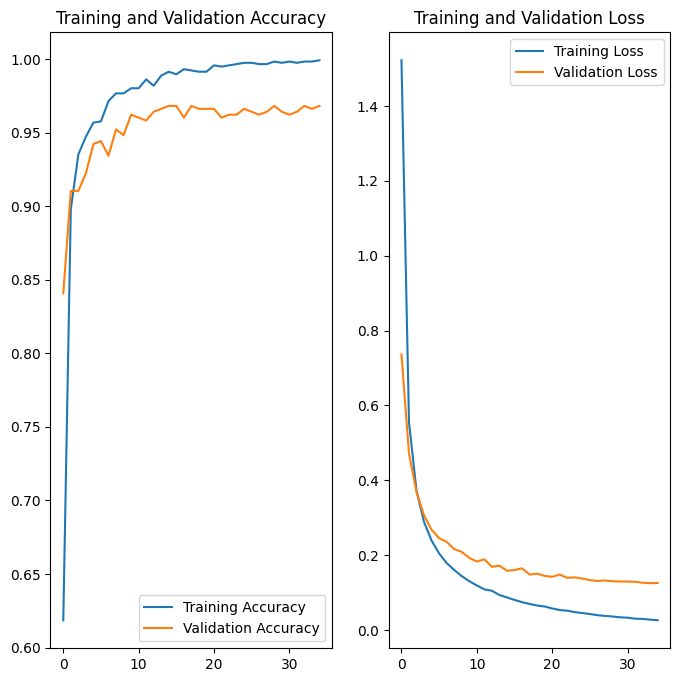

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [17]:
predicted = []
true_labels = []
dirs = list(test_dir.glob('*'))

for d in range(len(dirs)):
    dir = dirs[d]
    predicted.append([])

    for image in dir.glob('*/'):
        image = PIL.Image.open(image).resize((180, 180))
        img_array = tf.keras.utils.img_to_array(image)
        img_array = tf.expand_dims(img_array, 0)

        predictions = model.predict(img_array)
        score = tf.nn.softmax(predictions[0])

        result = np.argmax(score)
        predicted[d].append(result)
        true_labels.append(d)

1/1 [==============================] - 0s 56ms/step


Classification Report

In [18]:
flat_predicted = [item for sublist in predicted for item in sublist]

print(classification_report(true_labels, flat_predicted, digits=4))

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        53
           1     0.9815    0.9298    0.9550        57
           2     0.9750    0.9512    0.9630        41
           3     0.8072    0.9571    0.8758        70
           4     1.0000    1.0000    1.0000        54
           5     0.9556    0.9773    0.9663        44
           6     0.9792    0.9038    0.9400        52
           7     0.9865    0.9125    0.9481        80
           8     0.9020    0.9020    0.9020        51

    accuracy                         0.9462       502
   macro avg     0.9541    0.9482    0.9500       502
weighted avg     0.9508    0.9462    0.9471       502



Confusion Matrix

<AxesSubplot: >

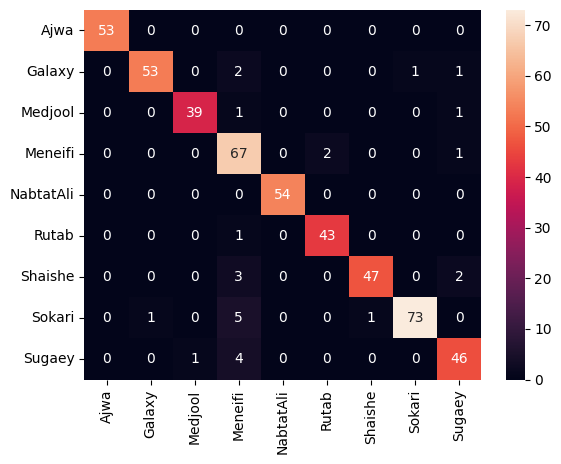

In [19]:
confusion_matrix = []
for l in range(len(predicted)):
    confusion_matrix.append([])
    for i in range(len(predicted)):
        confusion_matrix[l].append(predicted[l].count(i))

cm_df = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
sns.heatmap(cm_df, annot=True)

In [20]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('flutterModel.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\ahmad\AppData\Local\Temp\tmpnw8a6kwk\assets


INFO:tensorflow:Assets written to: C:\Users\ahmad\AppData\Local\Temp\tmpnw8a6kwk\assets
